Stock Price Prediction using Linear Regression  
Author: Zahra Shakeri  
Description:  
    This script downloads stock data from Yahoo Finance,  
    performs feature engineering, trains a Linear Regression model,  
    evaluates its performance, and predicts the next 7 days of stock prices.  

In [55]:
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
def fetch_stock_data(symbol, period):
    """
    Downloads historical stock data from Yahoo Finance.

    Args:
        symbol (str): Stock ticker (e.g., 'AAPL')
        period (str): Number of months of data (e.g., '12')

    Returns:
        pd.DataFrame: Stock price data with datetime index.
    """
    try:
        print(f"Fetching {symbol} data for last {period} months!")
        df = yf.download(symbol, period=f"{period}mo", progress=False)
        df = df.reset_index()
        df['Date'] = pd.to_datetime(df['Date'])
        filename = f"{symbol.lower()}_stock_data_{period}.csv"
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
        return df
    except Exception as error:
        print("Error fetching data:", error)
        return pd.DataFrame()

In [57]:
#Feature Engineering
def calculate_rsi(prices, periods=14):
    """Calculates the Relative Strength Index (RSI)."""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    loss = loss.replace(0, 0.0001)
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [58]:
def prepare_features(df):
    """Adds technical indicators and temporal features."""
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['RSI'] = calculate_rsi(df['Close'])
    df['Daily_Return'] = df['Close'].pct_change()
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Day_of_Month'] = df['Date'].dt.day
    df = df.dropna().reset_index(drop=True)
    return df

In [59]:
#Model Training
def train_model(df, features):
    """
    Trains Linear Regression model on selected features.
    Returns the model, evaluation metrics, and test data.
    """
    X = df[features]
    y = df['Close']


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    metrics = {
        'train_r2': f"{r2_score(y_train, train_pred):.4f}",
        'test_r2': f"{r2_score(y_test, test_pred):.4f}",
        'train_rmse': f"{np.sqrt(mean_squared_error(y_train, train_pred)):.2f}",
        'test_rmse': f"{np.sqrt(mean_squared_error(y_test, test_pred)):.2f}"
    }

    return model, scaler, metrics, (X_test, y_test, test_pred, df)


In [60]:
#Visualization
def plot_results(test_results, file_name):
    X_test, y_test, y_pred, df = test_results
    dates = df['Date'].tail(len(X_test)) 
    plt.style.use(style='default')
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    axes[0].plot(dates, y_test, label='Actual Price', color='blue')
    axes[0].plot(dates, y_pred, label='Prediction', color='red', linestyle='--')
    axes[0].set_title('Comparison of actual and predicted price', fontsize=10)
    axes[0].set_xlabel('Date', fontsize=10)
    axes[0].set_ylabel('Price (dollar)', fontsize=10)
    axes[0].legend()

    axes[1].scatter(y_test, y_pred, alpha=0.25)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1].set_title('Scatter diagram: comparison of actual and predicted price', fontsize=10)
    axes[1].set_xlabel('Actual Price', fontsize=10)
    axes[1].set_ylabel('Predicted Price', fontsize=10)

    plt.tight_layout()
    plt.savefig(file_name)
    print(f"Charts saved in {file_name}")
    plt.show()

In [61]:
#Forecasting
def predict_next_days(model, scaler, df, features, days=7):
    """
    Predicts the next `days` prices iteratively using the last available data.
    """
    predictions = []
    last_row = df.iloc[-1].copy()

    for _ in range(days):
        X_input = scaler.transform(last_row[features].values.reshape(1, -1))
        predicted_price = model.predict(X_input)[0]
        predictions.append(predicted_price)

        # Update features iteratively
        last_row['Close'] = predicted_price
        last_row['MA5'] = np.append(df['Close'].values, predicted_price)[-5:].mean()
        last_row['MA20'] = np.append(df['Close'].values, predicted_price)[-20:].mean()
        last_row['RSI'] = calculate_rsi(pd.Series(np.append(df['Close'].values, predicted_price))).iloc[-1]
        last_row['Daily_Return'] = (predicted_price - df['Close'].iloc[-1]) / df['Close'].iloc[-1]

    return predictions

In [62]:
#Save and Load Model
def save_model(model, scaler, filename="linear_regression_model.pkl"):
    joblib.dump({'model': model, 'scaler': scaler}, filename)
    print(f"Model saved to {filename}")


def load_model(filename="linear_regression_model.pkl"):
    data = joblib.load(filename)
    return data['model'], data['scaler']

Fetching AAPL data for last 36 months...
Data saved to aapl_stock_data_36.csv
Model saved to linear_regression_model.pkl

Model Performance:
train_r2: 0.9994
test_r2: 0.9952
train_rmse: 0.80
test_rmse: 1.35
Charts saved in Regression_Prediction.png


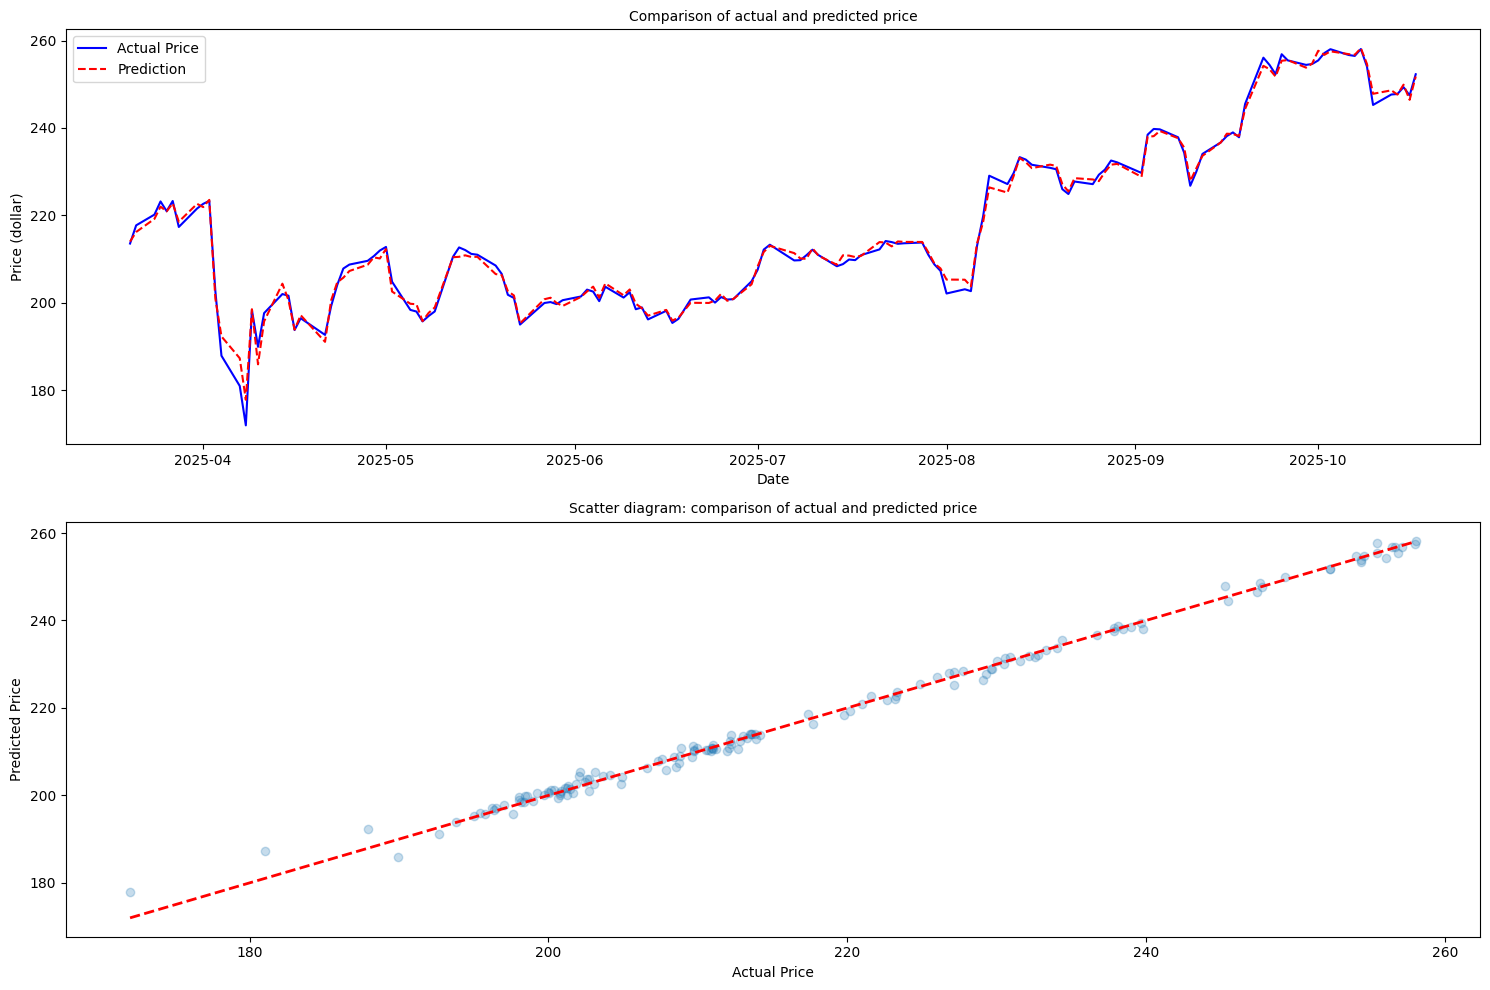


Next 7 days predicted prices:
Day1 : 251.775
Day2 : 250.736
Day3 : 250.461
Day4 : 250.389
Day5 : 250.370
Day6 : 250.365
Day7 : 250.363


In [63]:
#Main Runner    
def run():
    symbol = input("Enter stock ticker (e.g., AAPL): ").upper()
    months = input("Enter number of months (e.g., 12): ")

    df = fetch_stock_data(symbol, months)
    if df.empty:
        print("No data available. Exiting.")
        return

    df_prepared = prepare_features(df)
    features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'MA5', 'MA20', 'Daily_Return', 'Day_of_Week', 'Day_of_Month']

    model, scaler, metrics, test_results = train_model(df_prepared, features)
    save_model(model, scaler)

    print("\nModel Performance:")
    for key, val in metrics.items():
        print(f"{key}: {val}")

    plot_results(test_results , "Regression_Prediction.png")

    predictions = predict_next_days(model, scaler, df_prepared, features, days=7)
    print("\nNext 7 days predicted prices:")
    
    for i,p in enumerate(predictions , 1):
        print(f"Day{i} : {p[0]:.3f}")
        

if __name__ == "__main__":
    run()